### Importa módulos necessários

In [1]:
from pyspark.sql import SparkSession, Row, Window
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

### Inicia sessão Spark

In [2]:
spark = (
    SparkSession.builder.master("local[*]")
    .appName("exploratory-data-analysis")
    .config("spark.ui.port", "4040")
    .config("spark.ui.showConsoleProgress", "True")
    .getOrCreate()
)

### Carrega tabela da camada bronze

In [3]:
bronze_path = "/home/jovyan/data/bronze/salaries.parquet"
df = spark.read.parquet(bronze_path)

In [4]:
df.show(truncate=False)

+----------------+---------------+-------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+
|experience_level|employment_type|job_title          |salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|work_year|
+----------------+---------------+-------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+
|MI              |FT             |Data Manager       |117400|USD            |117400       |US                |0           |US              |M           |2024     |
|MI              |FT             |Data Manager       |62620 |USD            |62620        |US                |0           |US              |M           |2024     |
|SE              |FT             |Data Manager       |131200|USD            |131200       |US                |100         |US              |M           |2024     |
|SE             

In [5]:
df.select(
    [
        F.count(F.when(F.col(column).isNull(), column)).alias(f"{column}_null_count")
        for column in df.columns
    ]
).show(truncate=False)

+---------------------------+--------------------------+--------------------+-----------------+--------------------------+------------------------+-----------------------------+-----------------------+---------------------------+-----------------------+--------------------+
|experience_level_null_count|employment_type_null_count|job_title_null_count|salary_null_count|salary_currency_null_count|salary_in_usd_null_count|employee_residence_null_count|remote_ratio_null_count|company_location_null_count|company_size_null_count|work_year_null_count|
+---------------------------+--------------------------+--------------------+-----------------+--------------------------+------------------------+-----------------------------+-----------------------+---------------------------+-----------------------+--------------------+
|0                          |0                         |0                   |0                |0                         |0                       |0                           

In [6]:
df.describe().show(truncate=False)

+-------+----------------+---------------+----------------+------------------+---------------+------------------+------------------+-----------------+----------------+------------+-------------------+
|summary|experience_level|employment_type|job_title       |salary            |salary_currency|salary_in_usd     |employee_residence|remote_ratio     |company_location|company_size|work_year          |
+-------+----------------+---------------+----------------+------------------+---------------+------------------+------------------+-----------------+----------------+------------+-------------------+
|count  |64934           |64934          |64934           |64934             |64934          |64934             |64934             |64934            |64934           |64934       |64934              |
|mean   |NULL            |NULL           |NULL            |163455.40835309698|NULL           |158714.31233252224|NULL              |21.89068900729972|NULL            |NULL        |2023.80296916869

In [7]:
df.count()

64934

In [8]:
df.distinct().count()

30355

In [9]:
df.groupBy(df.columns).agg(F.count("*").alias("count")).sort(
    "count", ascending=False
).show(truncate=False)

+----------------+---------------+---------------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+-----+
|experience_level|employment_type|job_title                  |salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|work_year|count|
+----------------+---------------+---------------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+-----+
|SE              |FT             |Data Scientist             |160000|USD            |160000       |US                |100         |US              |M           |2024     |181  |
|SE              |FT             |Data Scientist             |110000|USD            |110000       |US                |100         |US              |M           |2024     |168  |
|SE              |FT             |Machine Learning Researcher|110000|USD            |110000       |US         

In [10]:
df_id = df.withColumn("id", F.monotonically_increasing_id()).select("id", *df.columns)

In [11]:
df_id.show(truncate=False)

+---+----------------+---------------+-------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+
|id |experience_level|employment_type|job_title          |salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|work_year|
+---+----------------+---------------+-------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+
|0  |MI              |FT             |Data Manager       |117400|USD            |117400       |US                |0           |US              |M           |2024     |
|1  |MI              |FT             |Data Manager       |62620 |USD            |62620        |US                |0           |US              |M           |2024     |
|2  |SE              |FT             |Data Manager       |131200|USD            |131200       |US                |100         |US              |M           |202

In [12]:
df_id.distinct().count()

64934

In [13]:
def count_categories(df, column):
    return df.groupBy(column).agg(F.count("*").alias("count"))

In [14]:
for column in df_id.columns:
    print(f"Analisando coluna {column} ...")
    count_categories(df_id, column).sort("count", ascending=False).show(truncate=False)

Analisando coluna id ...
+----+-----+
|id  |count|
+----+-----+
|26  |1    |
|29  |1    |
|474 |1    |
|964 |1    |
|1677|1    |
|1697|1    |
|1806|1    |
|1950|1    |
|2040|1    |
|2214|1    |
|2250|1    |
|2453|1    |
|2509|1    |
|2529|1    |
|2927|1    |
|3091|1    |
|3506|1    |
|3764|1    |
|4590|1    |
|4823|1    |
+----+-----+
only showing top 20 rows

Analisando coluna experience_level ...
+----------------+-----+
|experience_level|count|
+----------------+-----+
|SE              |38223|
|MI              |19381|
|EN              |5962 |
|EX              |1368 |
+----------------+-----+

Analisando coluna employment_type ...
+---------------+-----+
|employment_type|count|
+---------------+-----+
|FT             |64653|
|PT             |145  |
|CT             |120  |
|FL             |16   |
+---------------+-----+

Analisando coluna job_title ...
+------------------------------+-----+
|job_title                     |count|
+------------------------------+-----+
|Data Scientist  

In [15]:
senioridade = df.groupBy("experience_level").agg(F.count("*").alias("count"))

In [16]:
senioridade.show(truncate=False)

+----------------+-----+
|experience_level|count|
+----------------+-----+
|EX              |1368 |
|MI              |19381|
|EN              |5962 |
|SE              |38223|
+----------------+-----+



<Axes: xlabel='experience_level', ylabel='count'>

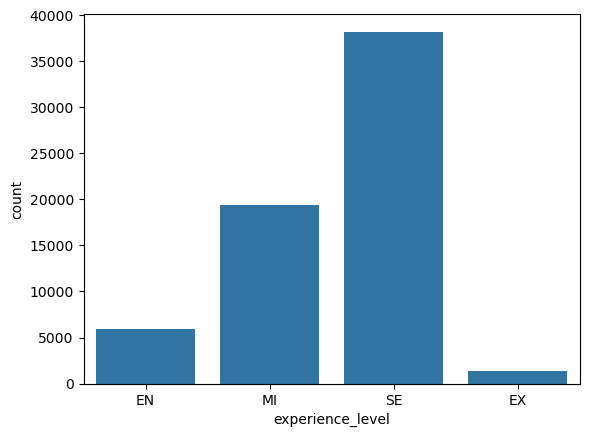

In [17]:
sns.barplot(
    senioridade.toPandas(),
    y="count",
    x="experience_level",
    order=["EN", "MI", "SE", "EX"],
)

In [18]:
contrato = df.groupBy("employment_type").agg(F.count("*").alias("count"))

In [19]:
contrato.show(truncate=False)

+---------------+-----+
|employment_type|count|
+---------------+-----+
|FT             |64653|
|PT             |145  |
|CT             |120  |
|FL             |16   |
+---------------+-----+



<Axes: xlabel='employment_type', ylabel='count'>

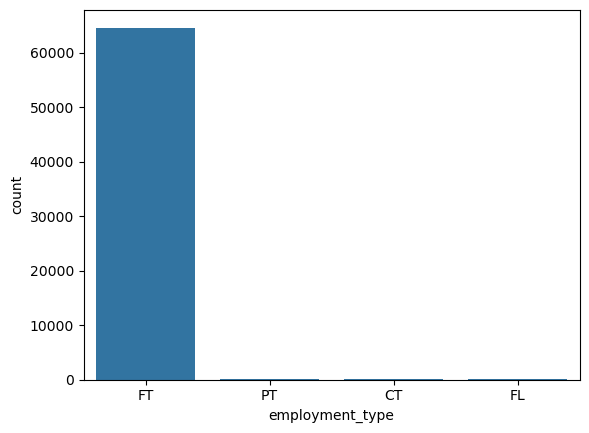

In [20]:
sns.barplot(contrato.toPandas(), x="employment_type", y="count")

In [21]:
moeda = (
    df.groupBy("salary_currency")
    .agg(F.count("*").alias("count"))
    .sort("count", ascending=False)
    .limit(10)
)

In [22]:
moeda.show(truncate=False)

+---------------+-----+
|salary_currency|count|
+---------------+-----+
|USD            |61750|
|GBP            |1773 |
|EUR            |1018 |
|CAD            |189  |
|INR            |69   |
|CHF            |29   |
|PLN            |21   |
|AUD            |16   |
|BRL            |15   |
|SGD            |10   |
+---------------+-----+



<Axes: xlabel='salary_currency', ylabel='count'>

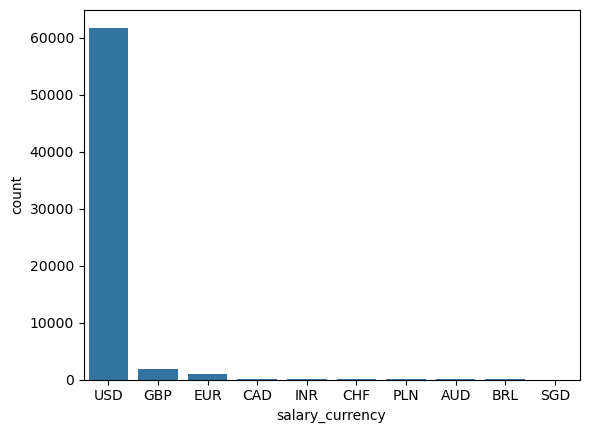

In [23]:
sns.barplot(moeda.toPandas(), x="salary_currency", y="count")

In [24]:
cargo = (
    df.groupBy("job_title")
    .agg(F.count("*").alias("count"))
    .sort("count", ascending=False)
    .limit(10)
)

In [25]:
cargo.show(truncate=False)

+-------------------------+-----+
|job_title                |count|
+-------------------------+-----+
|Data Scientist           |10570|
|Data Engineer            |8707 |
|Software Engineer        |6767 |
|Data Analyst             |6581 |
|Machine Learning Engineer|5433 |
|Engineer                 |3282 |
|Research Scientist       |2153 |
|Manager                  |2006 |
|Applied Scientist        |1478 |
|Data Architect           |1159 |
+-------------------------+-----+



<Axes: xlabel='count', ylabel='job_title'>

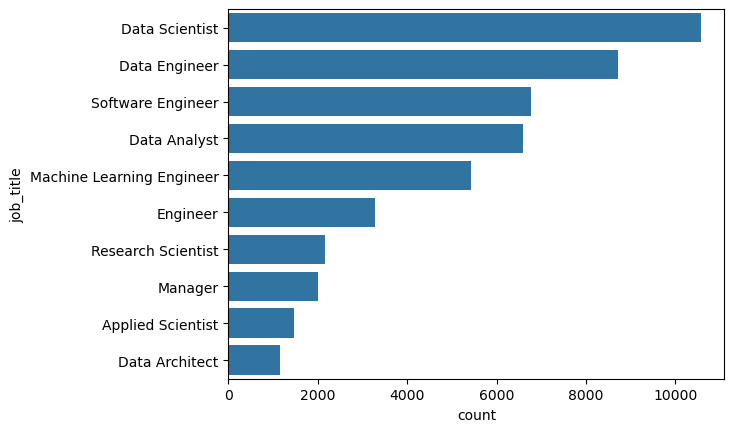

In [26]:
sns.barplot(cargo.toPandas(), y="job_title", x="count")

In [27]:
moradia = (
    df.groupBy("employee_residence")
    .agg(F.count("*").alias("count"))
    .sort("count", ascending=False)
    .limit(10)
)

In [28]:
moradia.show(truncate=False)

+------------------+-----+
|employee_residence|count|
+------------------+-----+
|US                |58762|
|CA                |2143 |
|GB                |1850 |
|DE                |206  |
|AU                |190  |
|ES                |177  |
|FR                |162  |
|IN                |131  |
|NL                |115  |
|LT                |106  |
+------------------+-----+



<Axes: xlabel='employee_residence', ylabel='count'>

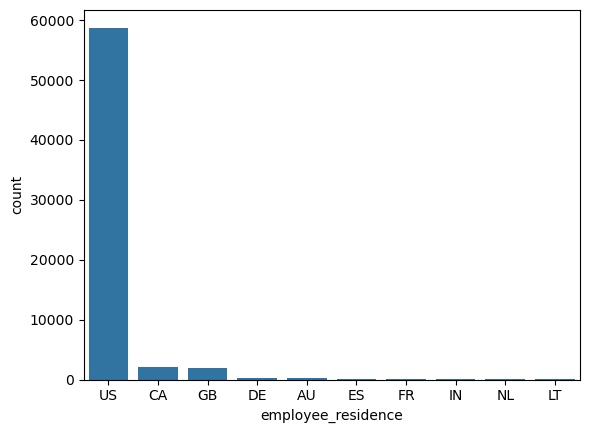

In [29]:
sns.barplot(moradia.toPandas(), x="employee_residence", y="count")

In [30]:
empresa = (
    df.groupBy("company_location")
    .agg(F.count("*").alias("count"))
    .sort("count", ascending=False)
    .limit(10)
)

In [31]:
empresa.show(truncate=False)

+----------------+-----+
|company_location|count|
+----------------+-----+
|US              |58814|
|CA              |2145 |
|GB              |1858 |
|DE              |214  |
|AU              |194  |
|ES              |173  |
|FR              |158  |
|NL              |115  |
|IN              |114  |
|LT              |106  |
+----------------+-----+



<Axes: xlabel='company_location', ylabel='count'>

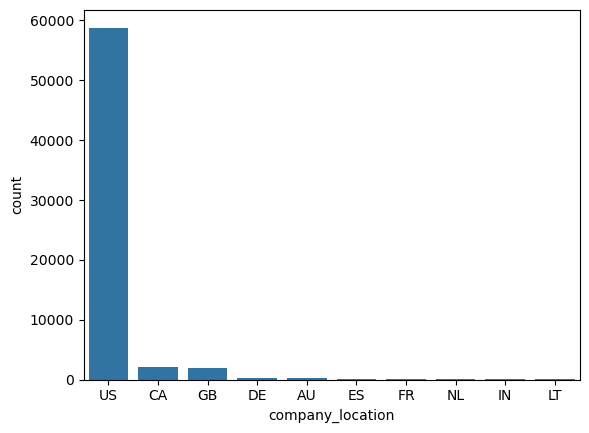

In [32]:
sns.barplot(empresa.toPandas(), x="company_location", y="count")

In [94]:
residence_location = (
    df.groupBy("employee_residence", "company_location")
    .agg(F.count("*").alias("count"))
    .sort("count", ascending=False)
)

In [95]:
residence_location.show(truncate=False)

+------------------+----------------+-----+
|employee_residence|company_location|count|
+------------------+----------------+-----+
|US                |US              |58755|
|CA                |CA              |2139 |
|GB                |GB              |1849 |
|DE                |DE              |201  |
|AU                |AU              |188  |
|ES                |ES              |171  |
|FR                |FR              |155  |
|NL                |NL              |113  |
|IN                |IN              |113  |
|LT                |LT              |106  |
|AT                |AT              |74   |
|IE                |IE              |68   |
|ZA                |ZA              |55   |
|BR                |BR              |55   |
|MX                |MX              |50   |
|PL                |PL              |47   |
|SK                |SK              |44   |
|AR                |AR              |41   |
|EG                |EG              |39   |
|FI                |FI          

<Axes: xlabel='company_location', ylabel='employee_residence'>

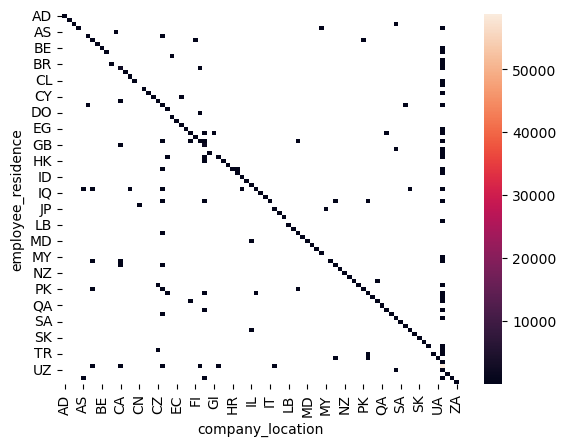

In [ ]:
sns.heatmap(
    residence_location.toPandas().pivot(
        index="employee_residence", columns="company_location", values="count"
    )
)

In [33]:
tamanho_empresa = (
    df.groupBy("company_size")
    .agg(F.count("*").alias("count"))
    .sort("count", ascending=False)
    .limit(10)
)

In [34]:
tamanho_empresa.show(truncate=False)

+------------+-----+
|company_size|count|
+------------+-----+
|M           |62563|
|L           |2167 |
|S           |204  |
+------------+-----+



<Axes: xlabel='company_size', ylabel='count'>

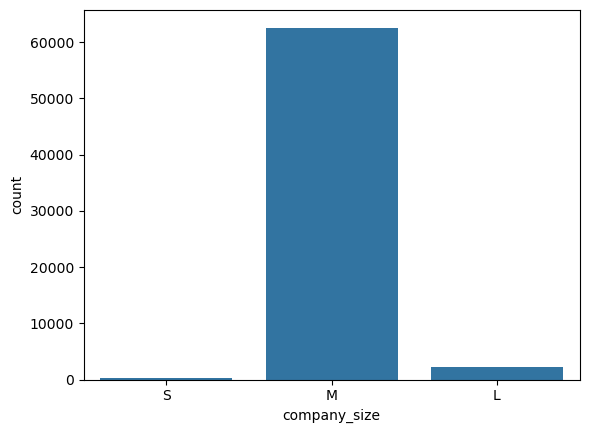

In [35]:
sns.barplot(
    tamanho_empresa.toPandas(), x="company_size", y="count", order=["S", "M", "L"]
)

In [36]:
df.filter(F.col("salary_currency") == "BRL").show(truncate=False)

+----------------+---------------+-----------------------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+
|experience_level|employment_type|job_title                          |salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|work_year|
+----------------+---------------+-----------------------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+
|SE              |FT             |Software Developer                 |368200|BRL            |75142        |BR                |0           |BR              |M           |2024     |
|SE              |FT             |Software Developer                 |216200|BRL            |44122        |BR                |0           |BR              |M           |2024     |
|SE              |FT             |Software Engineer                  |443000|BRL            |90408  

In [37]:
df.select("job_title").distinct().count()

267

In [38]:
df.groupBy("job_title").agg(F.count("*").alias("count")).sort(
    "count", ascending=False
).show(100, truncate=False)

+-----------------------------------------+-----+
|job_title                                |count|
+-----------------------------------------+-----+
|Data Scientist                           |10570|
|Data Engineer                            |8707 |
|Software Engineer                        |6767 |
|Data Analyst                             |6581 |
|Machine Learning Engineer                |5433 |
|Engineer                                 |3282 |
|Research Scientist                       |2153 |
|Manager                                  |2006 |
|Applied Scientist                        |1478 |
|Data Architect                           |1159 |
|Analyst                                  |1087 |
|Analytics Engineer                       |1032 |
|Research Engineer                        |958  |
|Product Manager                          |856  |
|Associate                                |768  |
|AI Engineer                              |547  |
|Business Intelligence Engineer           |542  |


In [39]:
df_job_focus = df_id.withColumn(
    "job_focus",
    F.when(F.contains(F.col("job_title"), F.lit("Engineer")), "Engineer")
    .when(F.contains(F.col("job_title"), F.lit("Scien")), "Scientist")
    .when(F.contains(F.col("job_title"), F.lit("Research")), "Scientist")
    .when(F.contains(F.col("job_title"), F.lit("Analy")), "Analyst")
    .when(F.contains(F.col("job_title"), F.lit("Architect")), "Architect")
    .when(F.contains(F.col("job_title"), F.lit("Model")), "Architect")
    .when(
        F.contains(F.col("job_title"), F.lit("Business Intelligence")),
        "Business Intelligence",
    )
    .when(F.contains(F.col("job_title"), F.lit("BI")), "Business Intelligence")
    .when(F.contains(F.col("job_title"), F.lit("Visual")), "Business Intelligence")
    .when(F.contains(F.col("job_title"), F.lit("Manager")), "Manager")
    .when(F.contains(F.col("job_title"), F.lit("Devel")), "Developer")
    .otherwise("Other"),
).withColumn(
    "data_roles",
    F.when(F.contains(F.col("job_title"), F.lit("Data")), F.lit(1))
    .when(F.contains(F.col("job_title"), F.lit("Analytics")), F.lit(1))
    .when(F.contains(F.col("job_title"), F.lit("AI")), F.lit(1))
    .when(F.contains(F.col("job_title"), F.lit("Machine Learning")), F.lit(1))
    .when(F.contains(F.col("job_title"), F.lit("ML")), F.lit(1))
    .when(
        F.contains(F.col("job_title"), F.lit("Business Intelligence")),
        F.lit(1),
    )
    .when(F.contains(F.col("job_title"), F.lit("BI")), F.lit(1))
    .when(F.contains(F.col("job_title"), F.lit("Deep Learning")), F.lit(1))
    .when(F.contains(F.col("job_title"), F.lit("ETL")), F.lit(1))
    .when(F.contains(F.col("job_title"), F.lit("NLP")), F.lit(1))
    .when(F.contains(F.col("job_title"), F.lit("Artificial Intelligence")), F.lit(1))
    .when(F.contains(F.col("job_title"), F.lit("Chatbot")), F.lit(1))
    .when(F.contains(F.col("job_title"), F.lit("Decision Scientist")), F.lit(1))
    .otherwise(F.lit(0)),
)

In [40]:
foco_cargo = (
    df_job_focus.groupBy("job_focus", "data_roles")
    .agg(F.count("*").alias("count"))
    .sort("count", ascending=False)
)

In [41]:
foco_cargo.show(truncate=False)

+---------------------+----------+-----+
|job_focus            |data_roles|count|
+---------------------+----------+-----+
|Engineer             |1         |16950|
|Engineer             |0         |13222|
|Scientist            |1         |11574|
|Analyst              |1         |7904 |
|Scientist            |0         |4091 |
|Manager              |0         |2862 |
|Other                |0         |1451 |
|Architect            |1         |1445 |
|Analyst              |0         |1433 |
|Other                |1         |1229 |
|Business Intelligence|1         |882  |
|Manager              |1         |785  |
|Developer            |0         |448  |
|Architect            |0         |414  |
|Developer            |1         |244  |
+---------------------+----------+-----+



<Axes: xlabel='count', ylabel='job_focus'>

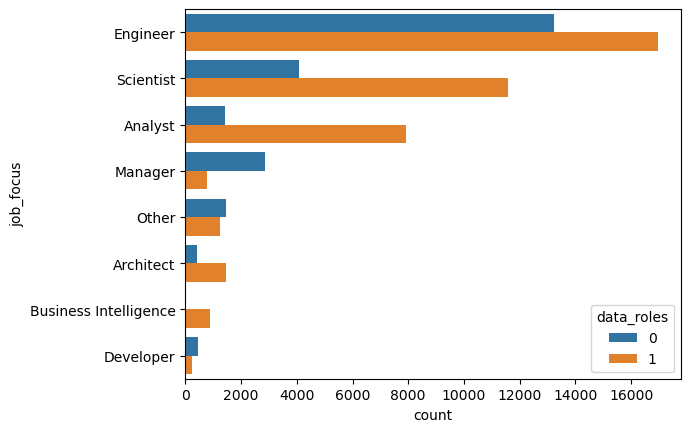

In [42]:
sns.barplot(foco_cargo.toPandas(), y="job_focus", x="count", hue="data_roles")

In [43]:
df_job_focus.groupBy("data_roles").agg(F.count("*").alias("count")).show(truncate=False)

+----------+-----+
|data_roles|count|
+----------+-----+
|1         |41013|
|0         |23921|
+----------+-----+



In [44]:
df_job_focus.filter(F.col("data_roles") == 1).groupBy("job_title").agg(
    F.count("*").alias("count")
).sort("count", ascending=False).show(300, truncate=False)

+----------------------------------------+-----+
|job_title                               |count|
+----------------------------------------+-----+
|Data Scientist                          |10570|
|Data Engineer                           |8707 |
|Data Analyst                            |6581 |
|Machine Learning Engineer               |5433 |
|Data Architect                          |1159 |
|Analytics Engineer                      |1032 |
|AI Engineer                             |547  |
|Business Intelligence Engineer          |542  |
|Data Manager                            |533  |
|Machine Learning Researcher             |423  |
|Business Intelligence Analyst           |417  |
|Data Specialist                         |344  |
|Machine Learning Scientist              |288  |
|Business Intelligence                   |284  |
|Business Intelligence Developer         |219  |
|BI Developer                            |194  |
|Head of Data                            |148  |
|Data Product Manage

In [45]:
df_job_focus.filter(F.col("data_roles") == 0).groupBy("job_title").agg(
    F.count("*").alias("count")
).sort("count", ascending=False).show(100, truncate=False)

+-----------------------------------------+-----+
|job_title                                |count|
+-----------------------------------------+-----+
|Software Engineer                        |6767 |
|Engineer                                 |3282 |
|Research Scientist                       |2153 |
|Manager                                  |2006 |
|Applied Scientist                        |1478 |
|Analyst                                  |1087 |
|Research Engineer                        |958  |
|Product Manager                          |856  |
|Associate                                |768  |
|Consultant                               |358  |
|Solutions Architect                      |328  |
|Research Analyst                         |319  |
|Engineering Manager                      |314  |
|Software Development Engineer            |293  |
|Software Developer                       |272  |
|Systems Engineer                         |260  |
|Site Reliability Engineer                |202  |


In [46]:
top_data_roles = (
    df_job_focus.filter(F.col("data_roles") == 1)
    .groupBy("job_title")
    .agg(F.count("*").alias("count"))
    .sort("count", ascending=False)
    .limit(5)
)

In [47]:
top_data_roles.show(truncate=False)

+-------------------------+-----+
|job_title                |count|
+-------------------------+-----+
|Data Scientist           |10570|
|Data Engineer            |8707 |
|Data Analyst             |6581 |
|Machine Learning Engineer|5433 |
|Data Architect           |1159 |
+-------------------------+-----+



<Axes: xlabel='count', ylabel='job_title'>

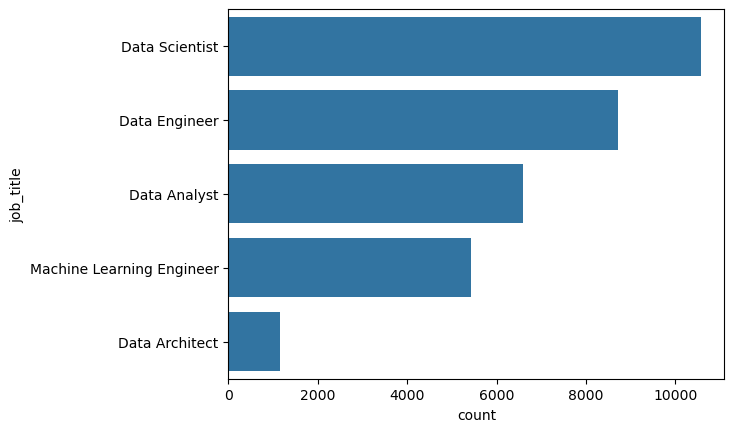

In [48]:
sns.barplot(top_data_roles.toPandas(), y="job_title", x="count")

In [49]:
top_non_data_roles = (
    df_job_focus.filter(F.col("data_roles") == 0)
    .groupBy("job_title")
    .agg(F.count("*").alias("count"))
    .sort("count", ascending=False)
    .limit(5)
)

In [50]:
top_non_data_roles.show(truncate=False)

+------------------+-----+
|job_title         |count|
+------------------+-----+
|Software Engineer |6767 |
|Engineer          |3282 |
|Research Scientist|2153 |
|Manager           |2006 |
|Applied Scientist |1478 |
+------------------+-----+



<Axes: xlabel='count', ylabel='job_title'>

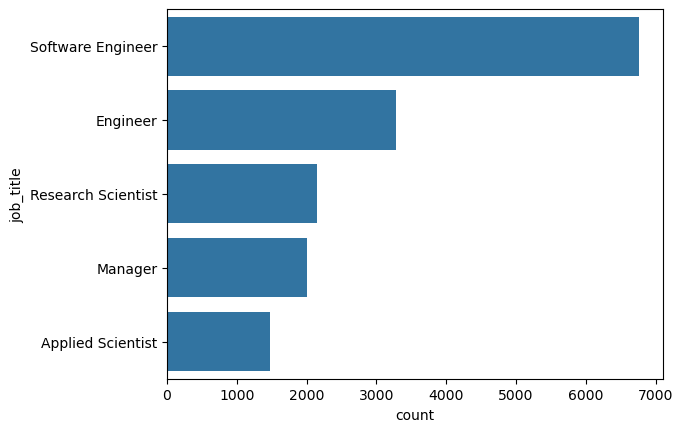

In [51]:
sns.barplot(top_non_data_roles.toPandas(), y="job_title", x="count")

In [52]:
df_job_focus.filter(F.col("job_focus") == "Other").distinct().count()

2680

In [53]:
df_job_focus.filter(F.col("job_focus") == "Other").groupBy("job_title").agg(
    F.count("*").alias("count")
).sort("count", ascending=False).show(100, truncate=False)

+-----------------------------------------+-----+
|job_title                                |count|
+-----------------------------------------+-----+
|Associate                                |768  |
|Consultant                               |358  |
|Data Specialist                          |344  |
|Head of Data                             |148  |
|Data Lead                                |90   |
|Data Management Specialist               |71   |
|Data Product Owner                       |54   |
|Statistical Programmer                   |54   |
|Data Strategist                          |52   |
|Technical Lead                           |50   |
|AI Specialist                            |48   |
|Data Integration Specialist              |41   |
|Principal Application Delivery Consultant|40   |
|Data Governance Specialist               |36   |
|Data Governance Lead                     |34   |
|Principal Statistical Programmer         |34   |
|Data Operations Specialist               |32   |


### Corrigir o salário em dólares pela inflação americana anual

[Referência](https://www.macrotrends.net/global-metrics/countries/USA/united-states/inflation-rate-cpi)

In [54]:
inflation = spark.createDataFrame(
    [
        Row(year=2020, rate=0.0123),
        Row(year=2021, rate=0.0470),
        Row(year=2022, rate=0.0800),
        Row(year=2023, rate=0.0412),
        Row(year=2024, rate=0.0),
    ]
)

In [55]:
inflation.show(truncate=False)

+----+------+
|year|rate  |
+----+------+
|2020|0.0123|
|2021|0.047 |
|2022|0.08  |
|2023|0.0412|
|2024|0.0   |
+----+------+



In [56]:
cumulative_inflation = (
    inflation.select("year")
    .alias("a")
    .join(inflation.alias("b"), F.col("b.year") >= F.col("a.year"), how="left")
    .select("a.year", "rate")
    .groupBy("year")
    .agg(F.sum(F.col("rate")).alias("cumulative_rate"))
)

In [57]:
cumulative_inflation.sort("year").show(truncate=False)

+----+-------------------+
|year|cumulative_rate    |
+----+-------------------+
|2020|0.1805             |
|2021|0.16820000000000002|
|2022|0.1212             |
|2023|0.0412             |
|2024|0.0                |
+----+-------------------+



<Axes: xlabel='year', ylabel='cumulative_rate'>

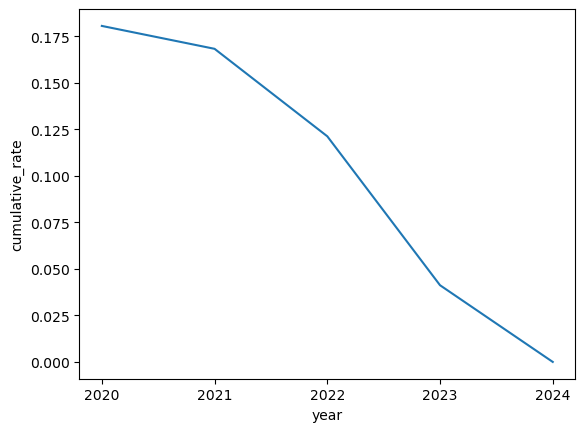

In [58]:
sns.lineplot(
    cumulative_inflation.withColumn("year", F.col("year").cast("string"))
    .sort("year")
    .toPandas(),
    x="year",
    y="cumulative_rate",
)

In [59]:
df_update = (
    df_job_focus.join(
        cumulative_inflation, df.work_year == cumulative_inflation.year, how="left"
    )
    .withColumn(
        "updated_salary",
        F.round(
            F.col("salary_in_usd") + F.col("salary_in_usd") * F.col("cumulative_rate"),
            2,
        ),
    )
    .sort("work_year")
)

In [60]:
df_update.show(truncate=False)

+-----------+----------------+---------------+-------------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+---------+----------+----+---------------+--------------+
|id         |experience_level|employment_type|job_title                |salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|work_year|job_focus|data_roles|year|cumulative_rate|updated_salary|
+-----------+----------------+---------------+-------------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+---------+----------+----+---------------+--------------+
|17179869184|EN              |FT             |Azure Data Engineer      |100000|USD            |100000       |MU                |0           |MU              |S           |2020     |Engineer |1         |2020|0.1805         |118050.0      |
|17179869204|EN              |FT            

<Axes: >

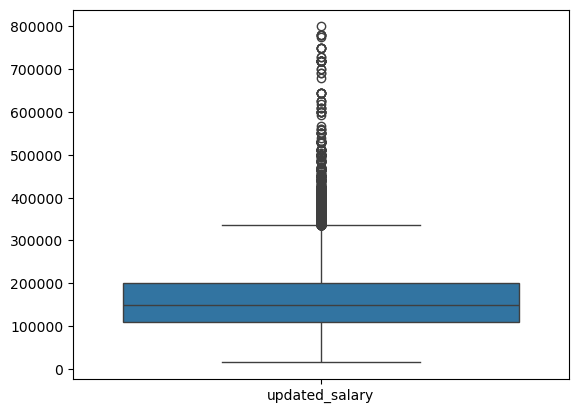

In [61]:
sns.boxplot(df_update.select("updated_salary").toPandas())

(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.,  600000.,  700000.,  800000.,  900000.]),
 [Text(-100000.0, 0, '−100000'),
  Text(0.0, 0, '0'),
  Text(100000.0, 0, '100000'),
  Text(200000.0, 0, '200000'),
  Text(300000.0, 0, '300000'),
  Text(400000.0, 0, '400000'),
  Text(500000.0, 0, '500000'),
  Text(600000.0, 0, '600000'),
  Text(700000.0, 0, '700000'),
  Text(800000.0, 0, '800000'),
  Text(900000.0, 0, '900000')])

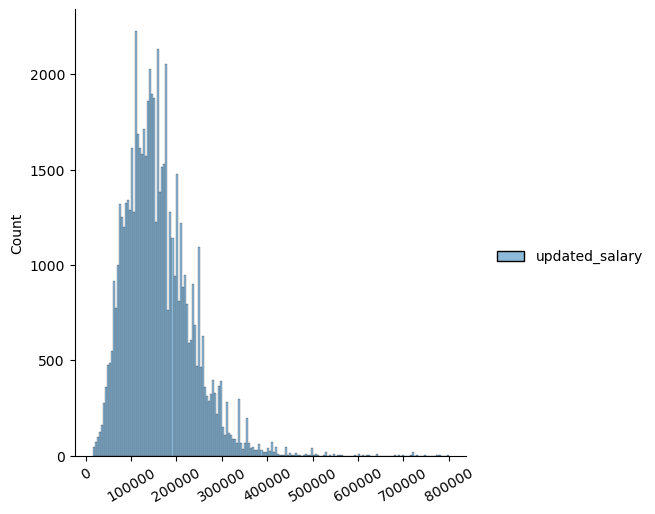

In [62]:
sns.displot(df_update.select("updated_salary").toPandas())
plt.xticks(rotation=30)

In [63]:
z_score = (
    df_update.withColumn(
        "mean", F.mean("updated_salary").over(Window.partitionBy(F.lit(1)))
    )
    .withColumn(
        "stddev", F.stddev_pop("updated_salary").over(Window.partitionBy(F.lit(1)))
    )
    .withColumn(
        "z_score", F.abs((F.col("updated_salary") - F.col("mean")) / F.col("stddev"))
    )
    .withColumn("limiar", F.when(F.col("z_score") > 3, 1).otherwise(0))
)

In [64]:
z_score.groupBy("limiar").agg(F.count("*").alias("count")).show(truncate=False)

+------+-----+
|limiar|count|
+------+-----+
|1     |611  |
|0     |64323|
+------+-----+



<Axes: xlabel='updated_salary', ylabel='limiar'>

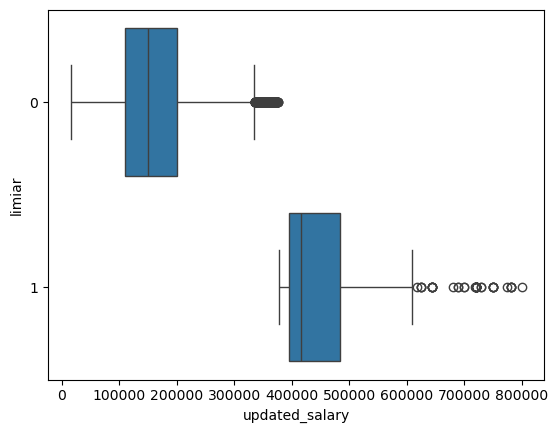

In [65]:
sns.boxplot(
    z_score.select(F.col("limiar").cast("string"), "updated_salary").toPandas(),
    x="updated_salary",
    y="limiar",
)

<Axes: >

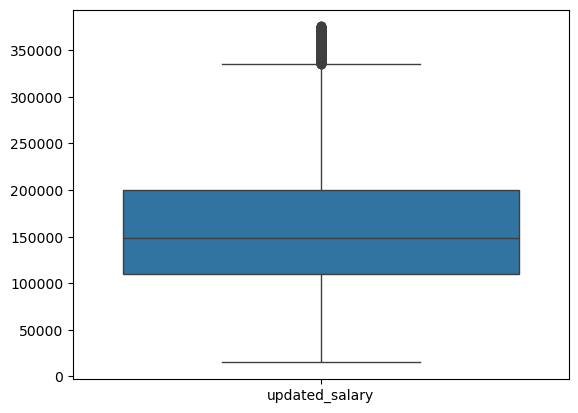

In [66]:
sns.boxplot(z_score.filter(F.col("limiar") == 0).select("updated_salary").toPandas())

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000.]),
 [Text(-50000.0, 0, '−50000'),
  Text(0.0, 0, '0'),
  Text(50000.0, 0, '50000'),
  Text(100000.0, 0, '100000'),
  Text(150000.0, 0, '150000'),
  Text(200000.0, 0, '200000'),
  Text(250000.0, 0, '250000'),
  Text(300000.0, 0, '300000'),
  Text(350000.0, 0, '350000'),
  Text(400000.0, 0, '400000')])

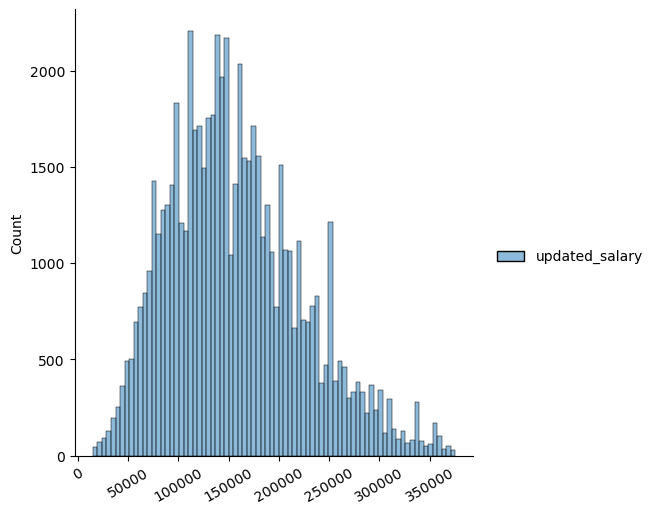

In [67]:
sns.displot(z_score.filter(F.col("limiar") == 0).select("updated_salary").toPandas())
plt.xticks(rotation=30)

<Axes: xlabel='updated_salary', ylabel='data_roles'>

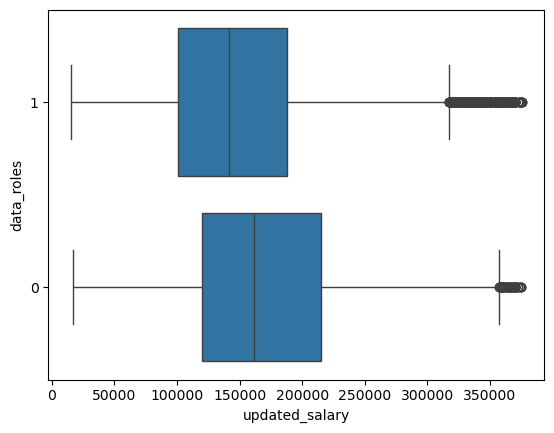

In [ ]:
sns.boxplot(
    z_score.filter(F.col("limiar") == 0)
    .select(F.col("data_roles").cast("string"), "updated_salary")
    .toPandas(),
    x="updated_salary",
    y="data_roles",
)

In [69]:
df_job_type = z_score.filter(F.col("limiar") == 0).withColumn(
    "job_type",
    F.when(F.col("remote_ratio") == 0, "Presencial")
    .when(F.col("remote_ratio") == 50, "Híbrido")
    .when(F.col("remote_ratio") == 100, "Remoto"),
)

In [70]:
df_job_type.show(truncate=False)

+-----------+----------------+---------------+-------------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+---------+----------+----+---------------+--------------+------------------+-----------------+-------------------+------+----------+
|id         |experience_level|employment_type|job_title                |salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|work_year|job_focus|data_roles|year|cumulative_rate|updated_salary|mean              |stddev           |z_score            |limiar|job_type  |
+-----------+----------------+---------------+-------------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------+---------+----------+----+---------------+--------------+------------------+-----------------+-------------------+------+----------+
|17179869184|EN              |FT             |Azure Data E

<Axes: xlabel='count', ylabel='job_type'>

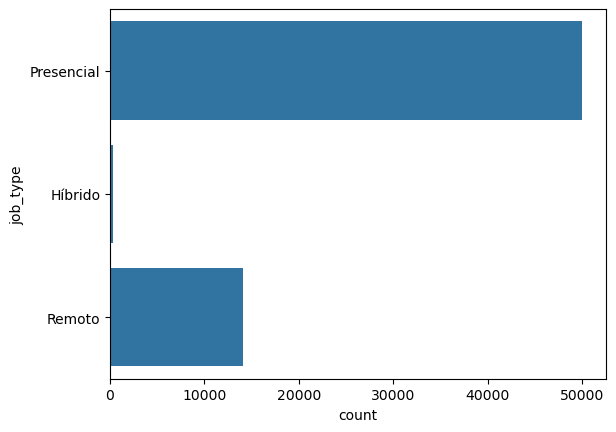

In [71]:
sns.barplot(
    df_job_type.groupBy("job_type").agg(F.count("*").alias("count")).toPandas(),
    x="count",
    y="job_type",
    order=["Presencial", "Híbrido", "Remoto"],
)

<Axes: xlabel='updated_salary', ylabel='job_type'>

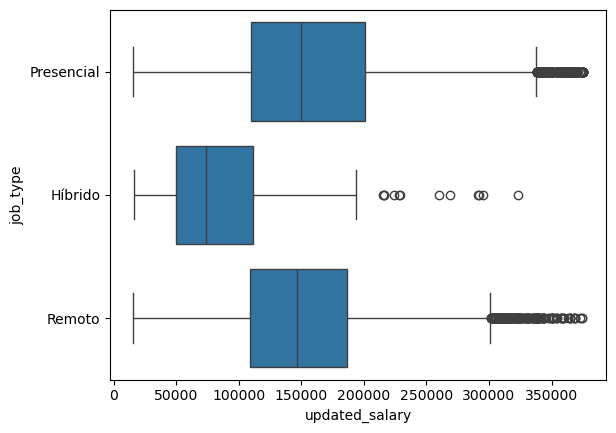

In [72]:
sns.boxplot(
    df_job_type.select("job_type", "updated_salary").toPandas(),
    x="updated_salary",
    y="job_type",
)

<Axes: xlabel='updated_salary', ylabel='experience_level'>

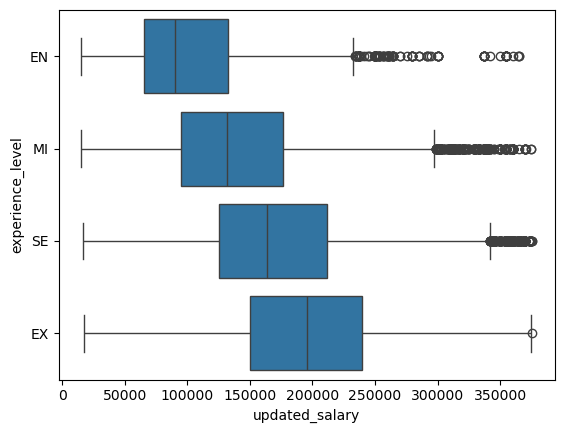

In [73]:
sns.boxplot(
    df_job_type.select("experience_level", "updated_salary").toPandas(),
    x="updated_salary",
    y="experience_level",
    order=["EN", "MI", "SE", "EX"],
)

In [74]:
def evaluate_response_variable(df, column):
    return df.groupBy(column).agg(
        F.count("*").alias("count"),
        F.mean("updated_salary").alias("mean_updated_salary"),
        F.median("updated_salary").alias("median_updated_salary"),
        F.min("updated_salary").alias("min_updated_salary"),
        F.max("updated_salary").alias("max_updated_salary"),
    )

In [75]:
for column in df_job_type.columns:
    evaluate_response_variable(df_job_type, column).sort(column).show(truncate=False)

+---+-----+-------------------+---------------------+------------------+------------------+
|id |count|mean_updated_salary|median_updated_salary|min_updated_salary|max_updated_salary|
+---+-----+-------------------+---------------------+------------------+------------------+
|0  |1    |117400.0           |117400.0             |117400.0          |117400.0          |
|1  |1    |62620.0            |62620.0              |62620.0           |62620.0           |
|2  |1    |131200.0           |131200.0             |131200.0          |131200.0          |
|3  |1    |95300.0            |95300.0              |95300.0           |95300.0           |
|4  |1    |68800.0            |68800.0              |68800.0           |68800.0           |
|5  |1    |48000.0            |48000.0              |48000.0           |48000.0           |
|6  |1    |264200.0           |264200.0             |264200.0          |264200.0          |
|7  |1    |143100.0           |143100.0             |143100.0          |143100.0

In [76]:
for column in df_job_type.columns:
    evaluate_response_variable(
        df_job_type.filter(F.col("data_roles") == 1), column
    ).sort(column).show(truncate=False)

+---+-----+-------------------+---------------------+------------------+------------------+
|id |count|mean_updated_salary|median_updated_salary|min_updated_salary|max_updated_salary|
+---+-----+-------------------+---------------------+------------------+------------------+
|0  |1    |117400.0           |117400.0             |117400.0          |117400.0          |
|1  |1    |62620.0            |62620.0              |62620.0           |62620.0           |
|2  |1    |131200.0           |131200.0             |131200.0          |131200.0          |
|3  |1    |95300.0            |95300.0              |95300.0           |95300.0           |
|6  |1    |264200.0           |264200.0             |264200.0          |264200.0          |
|7  |1    |143100.0           |143100.0             |143100.0          |143100.0          |
|20 |1    |312200.0           |312200.0             |312200.0          |312200.0          |
|21 |1    |175800.0           |175800.0             |175800.0          |175800.0

In [77]:
df_usa = df_job_type.withColumn(
    "usa_residence", F.when(F.col("employee_residence") == "US", 1).otherwise(0)
).withColumn("usa_company", F.when(F.col("company_location") == "US", 1).otherwise(0))

In [78]:
df_usa.groupBy("usa_residence", "usa_company").agg(F.count("*").alias("count")).show(
    truncate=False
)

+-------------+-----------+-----+
|usa_residence|usa_company|count|
+-------------+-----------+-----+
|1            |0          |7    |
|1            |1          |58183|
|0            |0          |6074 |
|0            |1          |59   |
+-------------+-----------+-----+



<Axes: xlabel='updated_salary', ylabel='experience_level'>

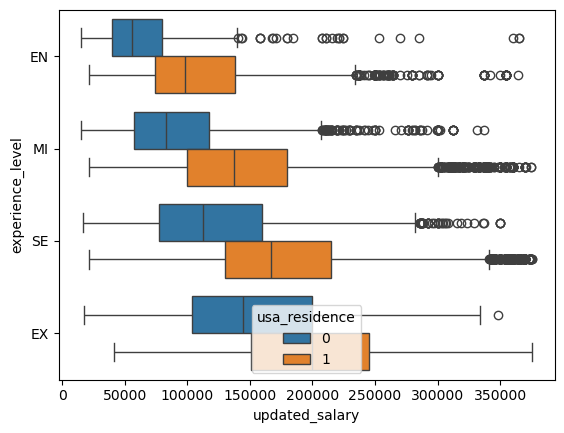

In [79]:
sns.boxplot(
    df_usa.select("experience_level", "usa_residence", "updated_salary").toPandas(),
    x="updated_salary",
    y="experience_level",
    hue="usa_residence",
    order=["EN", "MI", "SE", "EX"],
)

<Axes: xlabel='updated_salary', ylabel='experience_level'>

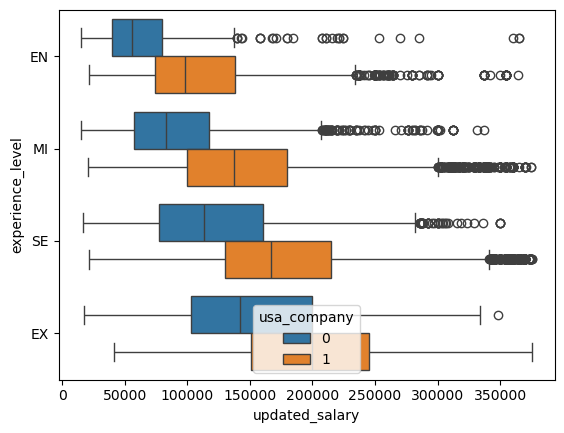

In [80]:
sns.boxplot(
    df_usa.select("experience_level", "usa_company", "updated_salary").toPandas(),
    x="updated_salary",
    y="experience_level",
    hue="usa_company",
    order=["EN", "MI", "SE", "EX"],
)